In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import rcParams
from skimage import io
from os.path import expanduser
from tqdm import tqdm
HOME = expanduser("~")
import os, sys
import cv2
import nipy
from nipy.labs.mask import compute_mask
from skimage import exposure, img_as_float
from skimage.exposure import rescale_intensity, adjust_gamma, equalize_adapthist
from scipy import stats
import pandas as pd
%load_ext autoreload
%autoreload 2

In [8]:
animal = 'DK55'
DIR = f'/net/birdstore/Active_Atlas_Data/data_root/pipeline_data/{animal}'
INPUT = os.path.join(DIR, 'preps', 'CH1', 'thumbnail')
MASK = os.path.join(DIR, 'preps','thumbnail_masked')
masks = sorted(os.listdir(MASK))
files = sorted(os.listdir(INPUT))

In [3]:
PATH = '/home/eddyod/programming/pipeline_utility'
sys.path.append(PATH)
from utilities.utilities_mask import fix_with_blob, scaled, lognorm, linnorm, fix_with_fill, normalize, equalize, equalized, remove_strip, trim_edges
from utilities.sqlcontroller import SqlController
sqlController = SqlController(animal)

Connecting dklab@192.168.1.12:3306


In [4]:
bad = [6,12,13,14,15,16,23,36,47,48,49,52,55,68,72,117,140,155,168,171,175,176, 188, 192,
       210,217, 218,241,263,267,275,295,323,327,331,339,351,354,363,369,380,388,394,395,
       417,421,422,423,424,425,427,428,429,431,432,433,435,437,445,447,451,452,453,455,456,457,458,459,
      460,461,462,463,464,465,466,467,468]
## really bad ones
reallybad = [36,155,171,217,218,295,380,388,431,432,433,437]
bads = ['{}.tif'.format(str(i).zfill(3)) for i in bad]
print(f'Need to manually fix {len(reallybad)} files or %{100*len(reallybad)/len(files)}')

Need to manually fix 12 files or %2.4742268041237114


In [12]:
def create_mask_pass1(img):
    mask1 = compute_mask(img, m=0.2, M=0.9, cc=False, opening=2, exclude_zeros=True)
    mask1 = mask1.astype(int)
    mask1[mask1==0] = 0
    mask1[mask1==1] = 255
    kernel = np.ones((5, 5), np.uint8)
    mask1 = cv2.dilate(mask1.astype(np.uint8), kernel, iterations=2)
    mask1 = mask1.astype(np.uint8)
    return mask1

#### Two pass method
1. Trims the edges of glue and junk
1. Runs through the existing fix with fill method (which has been modified again)
1. Then goes through the nipy compute_mask method (you'll need to install nipy from github

In [ ]:
names = []
norms = []
masks1 = []
passes1 = []
masks2 = []
passes2 = []
start, finish = (10,20)
lowVal, highVal, threshold = (0,0,0)

for file in tqdm(bads[start:finish]):
    infile = os.path.join(INPUT, file)
    img = io.imread(infile)
    normed = equalized(img)
    #gamma_corrected = exposure.adjust_gamma(img, 2)
    norms.append(normed)
    img = trim_edges(img)
    mask1 = create_mask_pass1(img)
    pass1 = cv2.bitwise_and(img, img, mask=mask1)
    masks1.append(mask1)    
    img2 = pass1.copy()
    passes1.append(img2)
    ## pass2
    mask2, lowVal, highVal, threshold = fix_with_fill(img2, debug=True)
    #mask2 = mask1
    pass2 = cv2.bitwise_and(img2, img2, mask=mask2)
    masks2.append(mask2)
    passes2.append(pass2)
    name = f'{file} {lowVal} {highVal} {threshold}'
    names.append(name)
    
fig, ax = plt.subplots(nrows=len(masks1), ncols=5, sharex=False, sharey=False)
plt.style.use('classic')
i = 0
for name, norm, mask1, pass1, mask2, pass2 in zip(names, norms, masks1, passes1, masks2, passes2):
    ax[i,0].set_title(f'{name}')
    ax[i,0].imshow(norm, cmap="gray")
    ax[i,1].set_title('1st pass mask')
    ax[i,1].imshow(mask1, cmap="gray")
    ax[i,2].set_title('1st pass img')
    ax[i,2].imshow(pass1, cmap="gray")
    ax[i,3].set_title('2nd pass mask')
    ax[i,3].imshow(mask2, cmap="gray")
    ax[i,4].set_title('2nd pass img')
    ax[i,4].imshow(pass2, cmap="gray")

    i += 1
fig.set_size_inches(np.array([18, 4 * len(masks2)]), forward=False)
plt.tight_layout()
plt.show()

In [49]:
def lognorm(img, limit):
    lxf = np.log(img + 0.005)
    lxf = np.where(lxf < 0, 0, lxf)
    xmin = min(lxf.flatten())
    xmax = max(lxf.flatten())
    return -lxf * limit / (xmax - xmin) + xmax * limit / (xmax - xmin)  # log of data and stretch 0 to limit


def linnorm(img, limit, dt):
    flat = img.flatten()
    hist, bins = np.histogram(flat, limit + 1)
    cdf = hist.cumsum()  # cumulative distribution function
    cdf = limit * cdf / cdf[-1]  # normalize
    # use linear interpolation of cdf to find new pixel values
    img_norm = np.interp(flat, bins[:-1], cdf)
    img_norm = np.reshape(img_norm, img.shape)
    return img_norm.astype(dt)

def scaled(img, mask, limit, epsilon=0.01):
    """
    This scales the image to the limit specified. You can get this value
    by looking at the combined histogram of the image stack.
    :param img: image we are working on.
    :param mask: binary mask file
    :param epsilon:
    :param limit: max value we wish to scale to
    :return: scaled image in 16bit format
    """
    _max = np.quantile(img[mask > 10], 1 - epsilon)
    # print('thr=%d, index=%d'%(vals[ind],index))
    _range = 2 ** 16 - 1
    scaled = img * (limit / _max)
    del img
    scaled[scaled > _range] = _range
    scaled = scaled * (mask > 10)
    return scaled.astype(np.uint16), _max

def get_binary_mask(img):
    '''
    Turn the RGB image into grayscale before
    applying an Otsu threshold to obtain a
    binary segmentation
    '''
    img8 = (img/256).astype('uint8')
    blurred_img = cv2.GaussianBlur(img8,(225,225),0)
    #return blurred_img
    #gray_img = cv2.cvtColor(blurred_img, cv2.COLOR_RGBA2GRAY)
    gray_img = blurred_img.copy()
    ret, otsu = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    kernel = np.ones((40,40),np.uint8)
    closed_mask = cv2.morphologyEx(otsu, cv2.MORPH_CLOSE, kernel)
    return closed_mask

Text(0.5, 1.0, 'fixed')

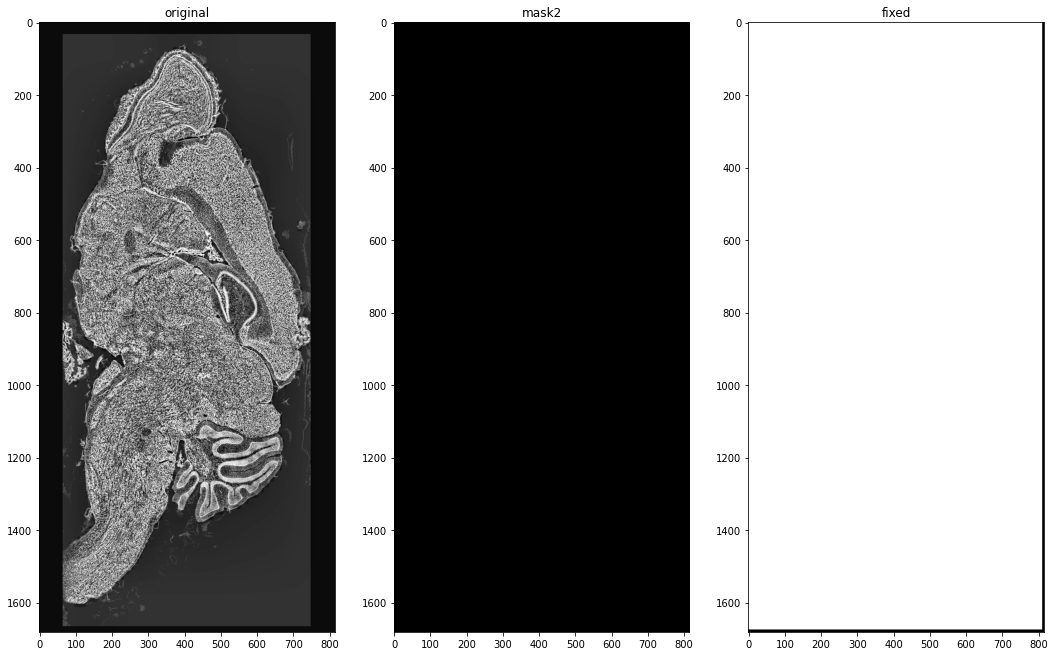

In [53]:
# 181, very dark
# 381, kinda light
file = '281.tif' 
infile = os.path.join(INPUT, file)
img = io.imread(infile)
img = trim_edges(img)
normed = equalized(img)
#maskfile = os.path.join(MASK, file)
#mask1 = io.imread(maskfile)
mask1 = create_mask_pass1(img)
img = cv2.bitwise_and(img, img, mask=mask1)

mask2 = get_binary_mask(img)
fixed = cv2.bitwise_and(img, img, mask=mask2)
fixed = equalize_adapthist(fixed)
#fixed = linnorm(fixed, 43000, mask1)
#rescaled = rescale_intensity(fixed.astype(np.float), (0,43000), (0, 2**16-1)).astype(np.uint16)
#clahe = cv2.createCLAHE(clipLimit=40.0, tileGridSize=(8, 8))
#fixed = clahe.apply(fixed)
# figure size in inches optional
rcParams['figure.figsize'] = 18 ,18

# display images
fig, ax = plt.subplots(1,3)
ax[0].imshow(normed, cmap="gray");
ax[0].set_title('original')
ax[1].imshow(mask2, cmap="gray");
ax[1].set_title('mask2')
ax[2].imshow(fixed, cmap="gray");
ax[2].set_title('fixed')
